# Synthetic Data Vault (SDV): A Python Library for Dataset Modeling

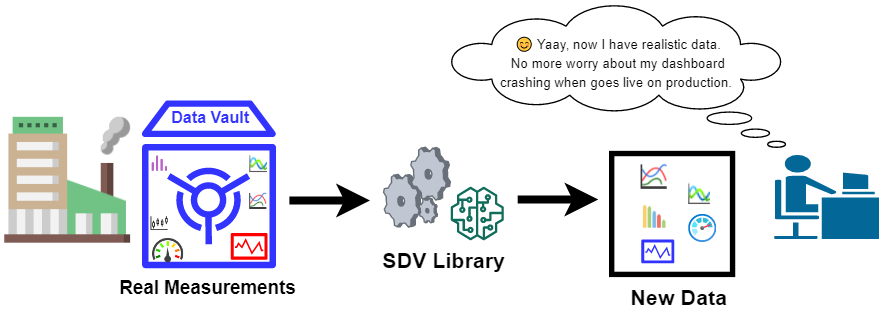

In [1]:
from IPython import display
display.Image("sdv_featured_image.png")

**Website: https://ealizadeh.com**

**Medium: https://medium.com/@ealizadeh**

Copyright © 2020 Esmaeil Alizadeh

-----

In data science, you usually need a realistic dataset to test your proof of concept. Creating fake data that captures the behavior of the actual data may sometimes be a rather tricky task. Several python packages try to achieve this task. Few popular python packages are [__Faker__ ](https://github.com/joke2k/faker/), [__Mimesis__](https://github.com/lk-geimfari/mimesis). However, there are mostly generating simple data like generating names, addresses, emails, _etc_. To create data that captures the attributes of a complex dataset, like having time-series that somehow capture the actual data's statistical properties, we will need a tool that generates data using different approaches. [Synthetic Data Vault (SDV)](https://sdv.dev/) python library is a tool that models complex datasets using statistical and machine learning models. 

### Why this library?
The main reason I'm interested in this tool is for system testing: It's much better to have datasets that are generated from the same actual underlying process. This way we can test our work/model in a realistic scenario rather than having unrealistic cases. There are other reasons why we need synthetic data such as data understanding, data compression, data augmentation, and data privacy [1]. 


The [Synthetic Data Vault (SDV)](https://sdv.dev) was first introduced in the paper [The Synthetic data vault](https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf), then used in the context of generative modeling a master thesis [The Synthetic Data Vault: Generative Modeling for Relational Databases](https://dspace.mit.edu/handle/1721.1/109616) by Neha Patki. Finally, the SDV library was developed as a part of Andrew Montanez's master thesis [SDV: An Open Source Library for Synthetic Data Generation](https://dai.lids.mit.edu/wp-content/uploads/2018/12/Andrew_MEng.pdf). There is also another master thesis [Synthesizing Tabular Data using conditional GAN](https://dai.lids.mit.edu/wp-content/uploads/2020/02/Lei_SMThesis_neo.pdf) by Lei Xu whose work was also integrated into this library.   

All these work and research were done in the MIT Data-to-AI laboratory under the supervision of Kalyan Veeramachaneni - a principal research scientist at MIT Laboratory for Information and Decision Systems (LIDS, MIT). 

The reason I'm bringing the history of the SDV is to appreciate the amount of work and research that has gone behind this library.


In this post, I will provide you with a few examples of how useful this tool is.

   _Image from Ref. [2] (Reprinted)_

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", bbox_inches="tight")

import sdv

# Timeseries

## Time Series Data Modeling using Probabilistic AutoRegressive (PAR)

A probabilistic autoregressive (PAR) model is used to model multi-type multivariate timeseries data. The SDV library has this model implemented in [`PAR` class](https://sdv.dev/SDV/user_guides/timeseries/par.html) (from timeseries module). 

Let's work out an example to explain different arguments of `PAR` class. We are going to work with a timeseries of temperature in multiple cities. The dataset will have the following column: _Date_, _City_, _Measuring Device_, _Where_.

In `PAR`, there are four types of columns considered in a dataset. 
1. __Sequence Index__: This is the data column that has the row dependecies (should be sorted like datetime or numeric values). In timeseries, this is usually the time axis. In our example, the sequence index will be the _Date_ column.
2. __Entity Columns__: These columns are the the abstract entities that forms the group of measurements, where the each group is a timeseries (hence the rows within each group should be sorted). However, rows of different entities are independent of each other. In our example, the enity column(s) will be only the _City_ column. By the way, we can have more columns as the argument type should be a list.
3. __Context Columns__: These columns provide information about the entities of the timeseries, and will not change over time. In other words, the `context_columns` should be constant within groups. In our example, _Measuring Device_ and _Where_ are the context columns.
4. __Data Columns__: Any other columns that do not belong to above categories will be considered as data columns. The `PAR` class does not have any argument to assign data columns. So, remaining columns that are not listed in any of previous three categories will automatically be considered as data columns. In our example, the _Noise_ column is the data column. 

In [3]:
from sdv.timeseries import PAR

In [4]:
actual_data = pd.read_csv("./daily_min_temperature_data_melbourne.csv")
actual_data["Date"] = pd.to_datetime(actual_data["Date"])

In [5]:
actual_data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### A single timeseries dataset
In this case, we only need to set the `sequence_index` of the `PAR()` class to the datetime column (the column illustrating the order of the timeseries sequence). 

In [6]:
model = PAR(sequence_index="Date")
model.fit(actual_data)
model.save("data_generation_model_single_city.pkl")

model = PAR.load("data_generation_model_single_city.pkl")

In [7]:
new_data = model.sample(num_sequences=1)   # may take few seconds to generate
new_data["Date"] = pd.to_datetime(new_data["Date"])

#### Stats: Actual data vs PAR generated data

In [8]:
stat_info1 = actual_data.describe().rename(columns={"Temp": "Real Data"})
stat_info2 = new_data.describe().rename(columns={"Temp": "PAR Generated Data"})

stat_info1.join(stat_info2)

,Real Data,PAR Generated Data
count,647.000000,647.000000
mean,11.012983,10.603925
std,4.745046,3.875709
min,0.000000,-2.156391
25%,7.500000,8.114472
50%,10.700000,10.643096
75%,14.200000,13.351023
max,26.300000,22.749782


### Multiple Timeseries

In [9]:
all_data = pd.read_csv("./fake_time_series_data_multiple_cities.csv")
all_data["Date"] = pd.to_datetime(all_data["Date"])

In [10]:
all_data.sample(10)

,Date,Temp,City,Measuring Device,Where,Noise
874,1981-08-16,25.3,City B,Device 2,Downtown,5.150951
334,1981-12-01,13.4,City A,Device 1,Airport,9.354288
800,1981-06-03,24.8,City B,Device 2,Downtown,7.443029
122,1981-05-03,14.0,City A,Device 1,Airport,8.821268
1316,1981-01-23,19.4,City C,Device 3,Suburb,7.489683
1336,1981-02-12,18.9,City C,Device 3,Suburb,7.271984
1656,1981-12-29,20.6,City C,Device 3,Suburb,2.569580
556,1982-07-11,4.0,City A,Device 1,Airport,4.332758
1495,1981-07-21,17.0,City C,Device 3,Suburb,5.589936
278,1981-10-06,13.2,City A,Device 1,Airport,4.237460


In [11]:
from sdv.timeseries import PAR

model = PAR(
    entity_columns=["City"],
    context_columns=["Measuring Device", "Where"],
    sequence_index="Date",
)
model.fit(all_data)
model.save("data_generation_model_multiple_city.pkl")

model = PAR.load("data_generation_model_multiple_city.pkl")

In [12]:
new_cities = model.sample(num_sequences=2)

In [13]:
cities = new_cities["City"].unique()
print(f"new cities: {cities}")

new cities: ['a' 'b']


In [14]:
all_data.drop(columns=["Noise"], inplace=True)
new_cities.drop(columns=["Noise"], inplace=True)

stat_info1 = all_data.describe().rename(columns={"Temp": "Original Data"})
stat_info2 = new_cities[new_cities["City"] == cities[0]].describe().rename(columns={"Temp": f"PAR Generated Data {cities[0]}"})
stat_info3 = new_cities[new_cities["City"] == cities[1]].describe().rename(columns={"Temp": f"PAR Generated Data {cities[1]}"})
stat_info4 = all_data[all_data["City"] == "City A"].describe().rename(columns={"Temp": "Original Data (City A)"})
stat_info5 = all_data[all_data["City"] == "City B"].describe().rename(columns={"Temp": "Original Data (City B)"})
stat_info6 = all_data[all_data["City"] == "City C"].describe().rename(columns={"Temp": "Original Data (City C)"})

stat_comparison = stat_info1.join(stat_info2).join(stat_info3).join(stat_info4).join(stat_info5).join(stat_info6)
stat_comparison

,Original Data,PAR Generated Data a,PAR Generated Data b,Original Data (City A),Original Data (City B),Original Data (City C)
count,1941.000000,647.000000,647.000000,647.000000,647.000000,647.000000
mean,17.679650,18.172292,18.346240,11.012983,26.012983,16.012983
std,7.835891,6.568995,6.480728,4.745046,4.745046,4.745046
min,0.000000,-0.620468,-3.060105,0.000000,15.000000,5.000000
25%,11.600000,13.654239,14.416982,7.500000,22.500000,12.500000
50%,17.000000,18.014439,18.403590,10.700000,25.700000,15.700000
75%,23.500000,22.864496,22.579155,14.200000,29.200000,19.200000
max,41.300000,36.263927,37.623863,26.300000,41.300000,31.300000


----

The other models:

### Relational Data
SDV can model relational datasets by generating data after you specify the data schema using `sdv.Metadata()`. Moreover, you can plot the entity-relationship (ER) diagram easily by their built-in function. After the metadata is ready, new data can be generated using Hierarchical Modeling Algorithm (HMA1). You can find more information [here](https://sdv.dev/SDV/user_guides/relational/index.html).

### Single Table Data
Modeling data for a single table datasets. Different statistical and deep learning models are used here, in particular:
- A [Gaussian Copula](https://sdv.dev/SDV/user_guides/single_table/gaussian_copula.html#gaussian-copula) to model the multivariate distribution, and 
- A Generative Adversarial Network (GAN) to model tabular data (based on the paper ["Modeling Tabular data using Conditional GAN"](https://arxiv.org/abs/1907.00503)
More information is available [here](https://sdv.dev/SDV/user_guides/single_table/index.html).


### Benchmarking Data
The SDV library provides the ability to benchmark synthetic data generators using [SDGym library](https://github.com/sdv-dev/SDGym) to evaluate the performance of synthesizer. You can find more inforamtion [here](https://sdv.dev/SDV/user_guides/benchmarking/single_table.html). 


# Conclusion

In this post, we went over the main features of the SDV library and how useful it is in generating anonymous datasets based on realistic data. The main features are modeling single table data, time-series, relational datasets, and also data benchmarking. One point to mention here is that you need to provide a large dataset for SDV models to train with. This way, the model can generate a meaningful dataset that truly captures the real process.  Give this library a try and let me know what you think?

Thanks for reading!

# References
[1] Lei Xu, [Synthesizing Tabular Data using Conditional GAN](https://dai.lids.mit.edu/wp-content/uploads/2020/02/Lei_SMThesis_neo.pdf), (2020), Master thesis, MIT

[2] N. Patki, R. Wedge, K. Veeramachaneni [The Synthetic data vault](https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf) (2016), International Conference on Data Science and Advance Analytics (DSAA-16)

[3] MIT News, [The real promise of synthetic data](https://news.mit.edu/2020/real-promise-synthetic-data-1016) (Ocotber 16, 2020)